In [2]:
import sys
sys.path.append("/u/dssc/zenocosini/helm_suite/MCQA_Benchmark")
from dadapy.data import Data
import torch
import numpy as np
import pickle
from collections import Counter, defaultdict
import pandas as pd

import matplotlib.pyplot as plt
import scipy as sp
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score


In [138]:
def get_composition(cluster_indices, subjects, subject_relevance):
    # subject integer identifier: frequency of the subjects
    cluster_subjects = subjects[cluster_indices]
    counts = Counter(np.array(cluster_subjects))
    # total_number of points in the cluster
    population = len(cluster_indices)

    # all subjects contained in a cluster
    clust_subjects = [t[0] for t in counts.most_common()]

    clust_percent = [t[1] / population for t in counts.most_common()]

    assert np.sum(clust_percent) > 0.9999, (clust_percent, np.sum(clust_percent))

    class_to_count = []
    current_perc = 0

    #
    for i in range(len(clust_subjects)):
        current_perc += clust_percent[i]
        # we consider a subject relevant only iif its presence is >0.2 the maximum popolated class
        if clust_percent[i] / clust_percent[0] > subject_relevance:
            class_to_count.append(clust_subjects[i])
        if current_perc > 0.9:
            break

    if clust_percent[0] < 0.3 or len(class_to_count) > 3:
        class_to_count = [f"mix of {len(class_to_count)} subjects"]

    return clust_subjects, clust_percent, class_to_count

In [249]:
base_dir = "/orfeo/cephfs/scratch/area/ddoimo/open/geometric_lens/repo/results/evaluated_test/questions_sampled13"
base_dir = "/orfeo/cephfs/scratch/area/ddoimo/open/geometric_lens/repo/results/evaluated_test/llama-3-8b/"

nshots = "5shot"
layer = 5
model = "llama-3-8b"
dirpath = f"{base_dir}/{model}/{nshots}"
dirpath = f"{base_dir}/{nshots}"

with open(f"{dirpath}/statistics_target.pkl", "rb") as f:
    stats = pickle.load(f)
    
# Creating mask
nsamples_per_subject = 300 # number of instance per sub
# def select_rows(group):
#     return group.head(min(len(group), nsamples_per_subject))
    
# series = pd.Series(stats['subjects'])
# series_crop = series.groupby(by=series ).apply(select_rows)
# mask = series_crop.index.get_level_values(1).values

# # we need to take just 100 samples per class (for simplicity)
# subjects = np.array(stats["subjects"])
# frequences = Counter(np.array(stats["subjects"])[mask]).values()
# # assert len(np.unique(list(frequences))) == 1
# # assert np.unique(list(frequences))[0] == nsamples_per_subject, np.unique(
#     # list(frequences)
# # )[0]


# subjects = np.array(stats["subjects"])[mask]
# # ground truth labels array where an integer corresponds to each subject
# # this ground truth label array should be (carefully!) adapted for cases
# # in which we do not have an equal number of samples per class

# gtl = np.repeat(np.arange(57), nsamples_per_subject)

series = pd.Series(stats['subjects'])
subjects = series.values
series_crop = series.groupby(series).apply(lambda k: k.head(nsamples_per_subject))
mask = series_crop.index.get_level_values(1).values
subject_to_index = {sub: index for index,sub in enumerate(series.unique())}
index_to_subject = {index: sub for index,sub in enumerate(series.unique())}
gtl = series_crop.apply(lambda k: subject_to_index[k]).values


In [250]:
#X = torch.load(f"{dirpath}/l{layer}_target.pt")
X_1 = torch.load(f"{dirpath}/l{layer-1}_target.pt")
X_2 = torch.load(f"{dirpath}/l{layer}_target.pt")
X_3 = torch.load(f"{dirpath}/l{layer+1}_target.pt")
X = torch.concat([X_1,X_2,X_3], dim=-1)
X = X.to(torch.float64).numpy()[mask]

# check we do not have opverlapping datapoints in case ramove tham from the relevant arrays
X_, indx, inverse = np.unique(X, axis=0, return_inverse=True, return_index=True)
sorted_indx = np.sort(indx)
X_sub = X[sorted_indx]
gtl = gtl[sorted_indx]
subjects = subjects[sorted_indx]


# mapping indices to subjects
# index_to_subject = {}
# for i in range(len(gtl)):
#     if gtl[i] in index_to_subject:
#         assert index_to_subject[gtl[i]] == subjects[i], (i, gtl[i], subjects[i])
#     else:
#         index_to_subject[gtl[i]] = subjects[i]


In [251]:
# ************************************************************************
# here we should try also halo = True
d = Data(coordinates=X_sub, maxk=300)
ids, _, _ = d.return_id_scaling_gride(range_max=300)
d.set_id(ids[4])
# d.return_id_scaling_gride(range_max=100)
# d.compute_density_PAk()
d.compute_density_kNN(k=32)
cluster_assignment = d.compute_clustering_ADP(Z=1.68, halo=True)
is_core = cluster_assignment != -1


In [252]:
# **************************************************************
# we consider only clusters with at least 30 points (this can be relaxed or decreased)
min_population = 1

cluster_mask = []
final_clusters_tmp = []
for cluster_indices in d.cluster_indices:
    if len(cluster_indices) > min_population:
        cluster_mask.append(True)
        final_clusters_tmp.append(cluster_indices)
    else:
        cluster_mask.append(False)

cluster_mask = np.array(cluster_mask)
assert cluster_mask.shape[0] == d.N_clusters


final_clusters = final_clusters_tmp
nclus = len(final_clusters)
assert nclus == np.sum(cluster_mask)
saddle_densities = d.log_den_bord[cluster_mask]
saddle_densities = saddle_densities[:, cluster_mask]
density_peak_indices = np.array(d.cluster_centers)[cluster_mask]


In [253]:
# *****************************************************
# pivotal similrity matrices of the clusters with a population > min_population

# key quantity for the dendogram is here: similarity matrix given by the density
# default from the advanced density peak paper. Other similarities can be tried in a second phase.
density_peaks = d.log_den[density_peak_indices]
Fmax = max(density_peaks)
Dis = []
for i in range(nclus):
    for j in range(i + 1, nclus):
        Dis.append(Fmax - saddle_densities[i][j])


# similar clusters are those whic are closer "small distance".
# we subtract the saddle point density to the max density peak highest saddles --> close categories
Dis = np.array(Dis)
# methods: 'single', 'complete', 'average', 'weighted', 'centroid'
DD = sp.cluster.hierarchy.linkage(Dis, method="weighted")


In [254]:
# ************************************************************************
# get subjects in the final clusters

# we consider a subject relevant in a cluster only if it has a frequancy 0.2*the most present class
subject_relevance = 0.2
clust_subjects = defaultdict(list)
clust_approx_subjects = defaultdict(list)
clust_percent = defaultdict(list)

for i in range(len(final_clusters)):
    sub, comp, approx = get_composition(
        final_clusters[i], subjects, subject_relevance
    )
    clust_subjects[i] = sub
    clust_approx_subjects[i] = approx
    clust_percent[i] = comp


labels = []
for i, (clust, subjects) in enumerate(clust_approx_subjects.items()):
    name = ""
    for sub in subjects:
        name += f" {sub},"
    labels.append(name.strip()[:-1])


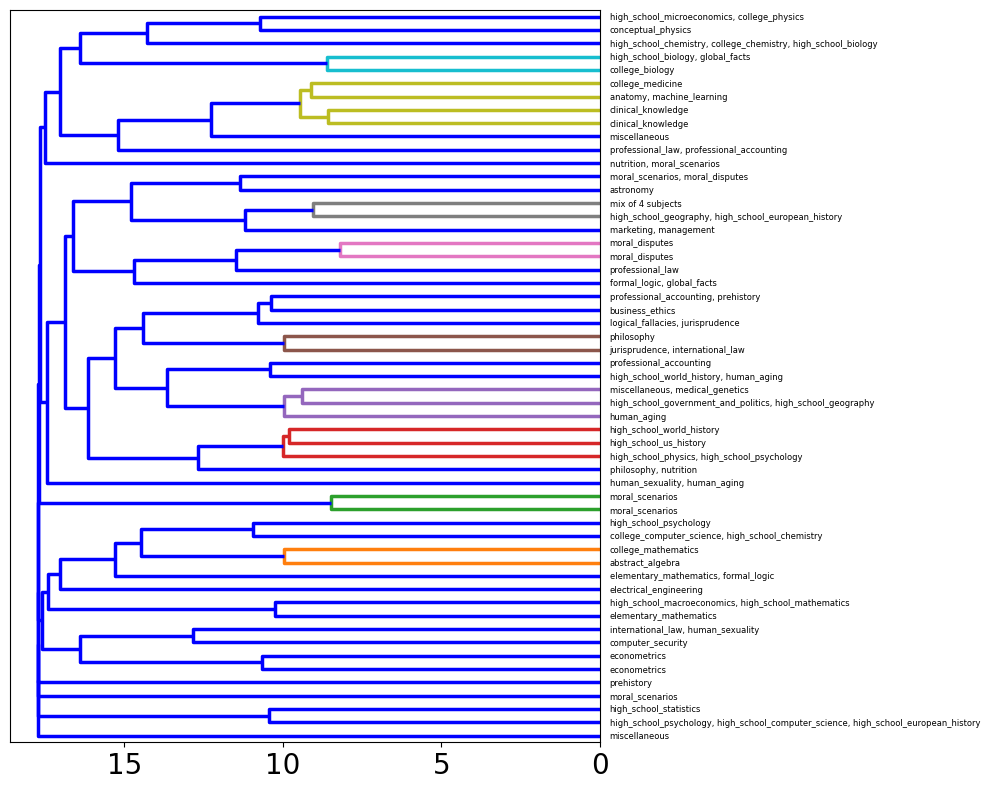

In [255]:
# ****************************************************
from common.config_plot import plot_config as params
thr = 10  # color threshold
fig, ax = plt.subplots(nrows=1, ncols=1)  # create figure & 1 axis
# truncate_mode: 'lastp', 'level', None
# labels = lab
# params = {'legend.fontsize': conf_size.legend,
#           'figure.figsize': (conf_size.width, conf_size.height),
#          'axes.labelsize': conf_size.xlabel,
#          'axes.titlesize':conf_size.title,
#          'xtick.labelsize':conf_size.xticks,
#          'ytick.labelsize':2}
dn = sp.cluster.hierarchy.dendrogram(
    DD,
    p=32,
    truncate_mode=None,
    color_threshold=thr,
    get_leaves=True,
    orientation="left",
    above_threshold_color="b",
    labels=labels,
)
plt.rcParams.update(params)
ax.tick_params(axis='y', which='major')
plt.tight_layout()
fig.savefig(f"dendogram/{nsamples_per_subject}/dendogram_{model}_layer_{layer}_{nshots}.png", dpi=150)

plt.show()

In [ ]:
!pwd